# Mountain Car

In [1]:
# Loading LegoRL library
import sys
sys.path.append('..\\LegoRL')  # path to folder with library

from LegoRL import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import gym

# Environment

In [3]:
import gym

class MountainCarLogger(gym.Wrapper):
    def step(self, a):
        s, r, d, info = self.env.step(a)
        
        self.max_height = max(self.max_height, self.h(s[0]))
        info["max_height"] = self.max_height
        
        return s, r, d, info
    
    def h(self, xs):
        return np.sin(3 * xs)*.45+.55
        
    def reset(self):
        s = self.env.reset()
        self.max_height = self.h(s[0])
        return s

In [4]:
def make_env():
    def _thunk():
        env = gym.make('MountainCar-v0')
        env = MountainCarLogger(env)
        return env
    return _thunk

# Network

In [5]:
MountainCarNN = lambda input_size, output_size: nn.Sequential(
                            nn.Linear(input_size, 20),
                            nn.ReLU(),
                            nn.Linear(20, 20),
                            nn.ReLU(),
                            nn.Linear(20, output_size))

In [6]:
MountainCarForward = lambda input_size, output_size: nn.Sequential(
                            nn.Linear(input_size, 20),
                            nn.ReLU(),
                            nn.Linear(20, 20),
                            nn.Tanh(),
                            nn.Linear(20, output_size))

# QR-DQN + Forward Model

In [7]:
QR_DQN = lambda runner: Composed(
    q_head          = QualityHead(network=MountainCarNN, representation=Quantile(Q, num_atoms=11)),
    policy          = eGreedy(greedy_policy="q_head"),
    replay          = ReplayBuffer(runner=runner, capacity=100000),
    sampler         = Sampler(replay="replay"),
    target_head     = Frozen(QualityHead)(source="q_head", timer=1000),
    target          = OneStep(evaluator="target_head"),
    critic_loss     = CriticLoss(sampler="sampler", critic="q_head", target="target"),
    trainer         = Trainer(transformations=["q_head"], losses=["critic_loss"]),
)

In [8]:
Curiosity = lambda runner, sampler: Composed(
    forward   = ForwardDynamics(network=MountainCarForward),
    loss      = DynamicsLoss(sampler=sampler, model="forward"),
    trainer   = Trainer(transformations=["forward"], losses=["loss"], optimizer_args={"lr": 1e-3}),
    motivated = IntrinsicMotivation(runner=runner, motivations=["forward"], cold_start=200, coeffs=[1000])
)

In [9]:
agent = Composed(
    player     = Player(policy="qrdqn.q_head", timer=2000, record_timer=10000),
    visualizer = Visualizer(),
    runner     = Runner(policy="qrdqn.policy", threads=8, timer=8, log_info=[("max_height", "max height")], env_max_T=200),
    qrdqn      = QR_DQN(runner="curiosity.motivated"),
    curiosity  = Curiosity(runner="runner", sampler="qrdqn.sampler")
)

..\c10/core/TensorImpl.h:864: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable.


In [10]:
system = System(agent, gamma=0.99, make_env=make_env, folder_name="Models/MountainCar QR-DQN Forward take3", save_timer=10000)

runner: environment initialization... Finished.
Initializing <qrdqn.q_head>:
  Input shape is torch.Size([2])
  Output shape is torch.Size([11, 3])
Initializing <qrdqn.target_head>:
  Input shape is torch.Size([2])
  Output shape is torch.Size([3])
Initializing <curiosity.forward>:
  Input shape is torch.Size([5])
  Output shape is torch.Size([2])


In [11]:
agent

<player>: Plays full game each 2000 iteration using <qrdqn.q_head> policy
<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in 8 parallel environments each 8 iteration using <qrdqn.policy> policy
<qrdqn>:
    <q_head>: Head, modeling Q-function in quantile form with 11 atoms
    <policy>: Acts randomly with eps-probability, otherwise calls <qrdqn.q_head>
    <replay>: Stores observations from <curiosity.motivated>
    <sampler>: Samples mini-batches from <qrdqn.replay>
    <target_head>: Copy of <qrdqn.q_head>, updated each 1000 iteration
    <target>: Calculates one-step TD target using <qrdqn.target_head> as next state estimator
    <critic_loss>: Calculates TD loss for <qrdqn.q_head> using <qrdqn.target> as target calculator and data from <qrdqn.sampler>
    <trainer>: Trains <qrdqn.q_head> using following losses: <qrdqn.critic_loss>
    
<curiosity>:
    <forward>: Predicts next state representation from current and action
    <loss>: Calculates loss for <qrdqn.

In [12]:
system.run(debug=True)

curiosity.motivated: no new observations found, no observation generated.
qrdqn.replay: no new observations found.
qrdqn.trainer: initiates loss computation.
  qrdqn.sampler: cold start regime: batch is not sampled.
  qrdqn.critic_loss: no batch is found, loss is None.
qrdqn.trainer: loss is None; no optimization step is performed.
curiosity.trainer: initiates loss computation.
  qrdqn.sampler: returns same sample.
  curiosity.loss: no batch is found, loss is None.
curiosity.trainer: loss is None; no optimization step is performed.


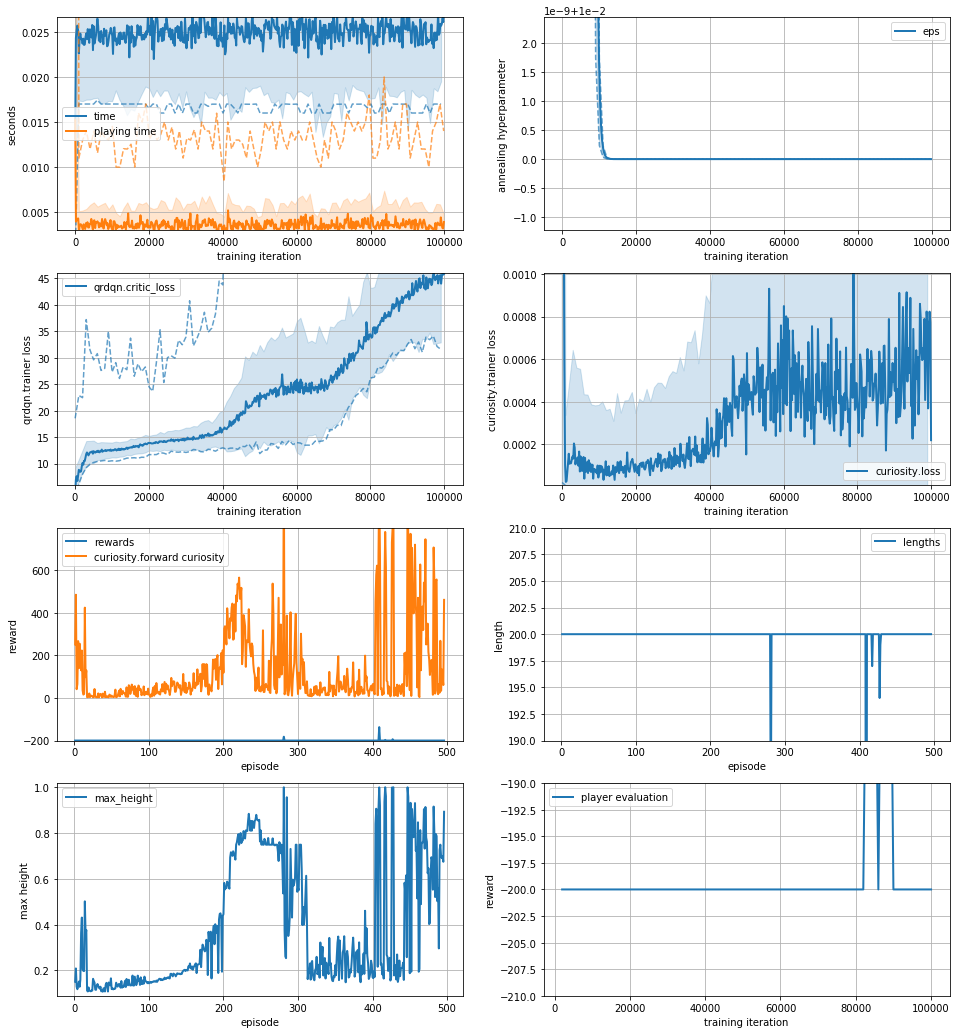

In [13]:
system.run(100000)

In [14]:
agent.runner.fps

40.13316729670128